# 2. Poisson LDS

We can swap out the Gaussian emissions from earlier with a Poisson GLM model.

In [1]:
%load_ext autoreload
%autoreload 2

### Imports and Plotting Functions

In [4]:
import jax.numpy as np
import jax.random as jr
import jax.experimental.optimizers as optimizers
from jax import jit, value_and_grad, vmap
from tqdm.auto import trange

import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp

from ssm.lds.models import GaussianLDS, PoissonLDS
from ssm.distributions.linreg import GaussianLinearRegression

from ssm.utils import random_rotation
from ssm.plots import plot_dynamics_2d

from matplotlib.gridspec import GridSpec 

def plot_emissions(states, data):
    latent_dim = states.shape[-1]
    emissions_dim = data.shape[-1]
    num_timesteps = data.shape[0]
    
    plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 1, height_ratios=(1, emissions_dim / latent_dim))

    # Plot the continuous latent states
    lim = abs(states).max()
    plt.subplot(gs[0])
    for d in range(latent_dim):
        plt.plot(states[:, d] + lim * d, '-')
    plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
    plt.xticks([])
    plt.xlim(0, num_timesteps)
    plt.title("Sampled Latent States")

    lim = abs(data).max()
    plt.subplot(gs[1])
    for n in range(emissions_dim):
        plt.plot(data[:, n] - lim * n, '-k')
    plt.yticks(-np.arange(emissions_dim) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(emissions_dim)])
    plt.xlabel("time")
    plt.xlim(0, num_timesteps)

    plt.title("Sampled Emissions")
    plt.tight_layout()
    

def plot_emissions_poisson(states, data):
    
    latent_dim = states.shape[-1]
    emissions_dim = data.shape[-1]
    num_timesteps = data.shape[0]
    
    plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 1, height_ratios=(1, emissions_dim / latent_dim))

    # Plot the continuous latent states
    lim = abs(states).max()
    plt.subplot(gs[0])
    for d in range(latent_dim):
        plt.plot(states[:, d] + lim * d, '-')
    plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
    plt.xticks([])
    plt.xlim(0, time_bins)
    plt.title("Sampled Latent States")

    lim = abs(data).max()
    plt.subplot(gs[1])
    plt.imshow(data.T, aspect="auto", interpolation="none")
    plt.xlabel("time")
    plt.xlim(0, time_bins)
    plt.yticks(ticks=np.arange(emissions_dim))
    plt.ylabel("Neuron")

    plt.title("Sampled Emissions (Counts / Time Bin)")
    plt.tight_layout()

    plt.colorbar()
    
def plot_dynamics(lds, states):
    q = plot_dynamics_2d(lds._dynamics.weights, 
                         bias_vector=lds._dynamics.bias,
                         mins=states.min(axis=0),
                         maxs=states.max(axis=0),
                         color="blue")
    plt.plot(states[:,0], states[:,1], lw=2, label="Latent State")
    plt.plot(states[0,0], states[0,1], '*r', markersize=10, label="Initial State")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Latent States & Dynamics")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

def extract_trial_stats(trial_idx, posterior, all_data, all_states, fitted_lds, true_lds):
    # Posterior Mean
    Ex = posterior.mean[trial_idx]
    states = all_states[trial_idx]
    data = all_data[trial_idx]

    # Compute the data predictions
    C = fitted_lds.emissions_matrix
    d = fitted_lds.emissions_bias

    Ey = Ex @ C.T + d
    Covy = C @ posterior.covariance[trial_idx] @ C.T

    # basically recover the "true" input to the Poisson GLM
    Ey_true = states @ true_lds.emissions_matrix.T + true_lds.emissions_bias

    return states, data, Ex, Ey, Covy, Ey_true

def compare_dynamics(Ex, states, data):
    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    q = plot_dynamics_2d(true_lds._dynamics.weights, 
                        bias_vector=true_lds._dynamics.bias,
                        mins=states.min(axis=0),
                        maxs=states.max(axis=0),
                        color="blue",
                        axis=axs[0])
    axs[0].plot(states[:,0], states[:,1], lw=2)
    axs[0].plot(states[0,0], states[0,1], '*r', markersize=10, label="$x_{init}$")
    axs[0].set_xlabel("$x_1$")
    axs[0].set_ylabel("$x_2$")
    axs[0].set_title("True Latent States & Dynamics")

    q = plot_dynamics_2d(fitted_lds._dynamics.weights, 
                        bias_vector=fitted_lds._dynamics.bias,
                        mins=Ex.min(axis=0),
                        maxs=Ex.max(axis=0),
                        color="red",
                        axis=axs[1])

    axs[1].plot(Ex[:,0], Ex[:,1], lw=2)
    axs[1].plot(Ex[0,0], Ex[0,1], '*r', markersize=10, label="$x_{init}$")
    axs[1].set_xlabel("$x_1$")
    axs[1].set_ylabel("$x_2$")
    axs[1].set_title("Simulated Latent States & Dynamics")
    plt.tight_layout()
    plt.show()

def compare_smoothened_predictions(Ey, Ey_true, Covy, data):
    data_dim = data.shape[-1]

    plt.figure(figsize=(15, 6))
    plt.plot(Ey_true + 10 * np.arange(data_dim))
    plt.plot(Ey + 10 * np.arange(data_dim), '--k')
    for i in range(data_dim):
        plt.fill_between(np.arange(len(data)),
                        10 * i + Ey[:, i] - 2 * np.sqrt(Covy[:, i, i]),
                        10 * i + Ey[:, i] + 2 * np.sqrt(Covy[:, i, i]), 
                        color='k', alpha=0.25)
    plt.xlabel("time")
    plt.ylabel("data and predictions (for each neuron)")

    plt.plot([0], '--k', label="Predicted") # dummy trace for legend
    plt.plot([0], '-k', label="True")
    plt.legend(loc="upper right")
    plt.show()

In [7]:
# Some parameters to define our model
emissions_dim = 10  # num_neurons
latent_dim = 2
seed = jr.PRNGKey(0)

# Initialize our true Poisson LDS model
true_lds = PoissonLDS(num_latent_dims=latent_dim, 
                      num_emission_dims=emissions_dim,
                      seed=seed)

### Sample some synthetic data from the Poisson LDS

In [8]:
import warnings

num_trials = 5
time_bins = 200

# catch annoying warnings of tfp Poisson sampling
rng = jr.PRNGKey(0)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    all_states, all_data = true_lds.sample(key=rng, num_steps=time_bins, num_samples=num_trials)

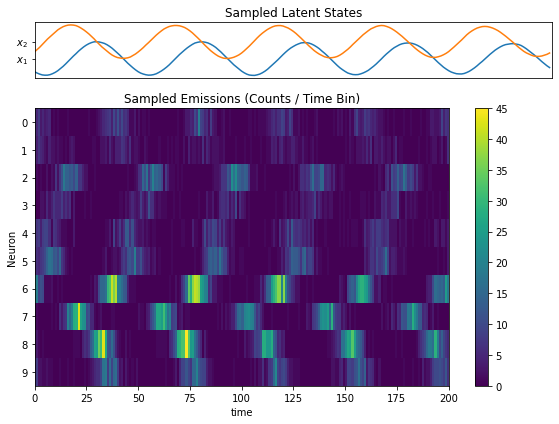

In [9]:
plot_emissions_poisson(all_states[0], all_data[0])

## Inference: let's fit a Poisson LDS to our data

Since we have a Poisson emissions model, we can no longer perform exact EM.

Instead, we perform Laplace EM, in which we approximate the posterior using a Laplace (Gaussian) approximation.

In [10]:
latent_dim = 2
seed = jr.PRNGKey(32) # NOTE: different seed!

test_lds = PoissonLDS(num_emission_dims=emissions_dim,
                      num_latent_dims=latent_dim,
                      seed=seed)

In [12]:
from ssm.inference.laplace_em import laplace_em

rng = jr.PRNGKey(10)
elbos, fitted_lds, posteriors = laplace_em(rng, 
                                          test_lds,
                                          all_data,
                                          num_iters=25, 
                                          laplace_mode_fit_method="BFGS")

  0%|          | 0/25 [00:00<?, ?it/s]

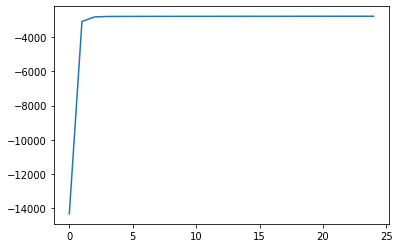

In [13]:
plt.plot(elbos)
plt.show()

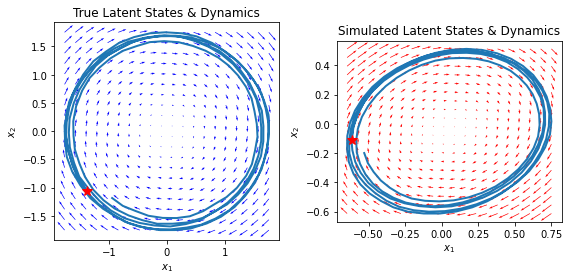

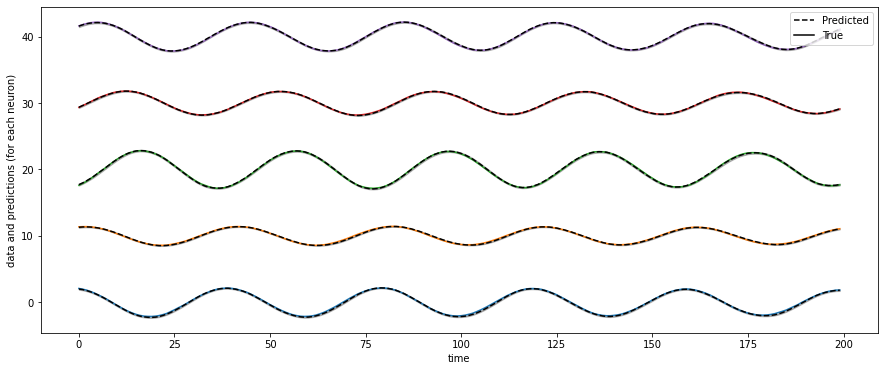

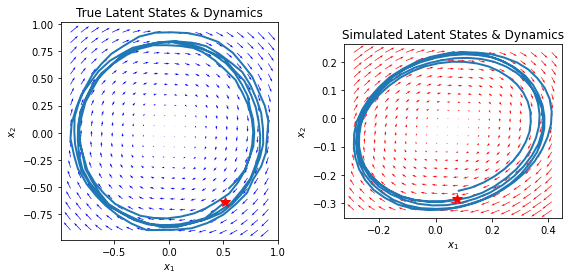

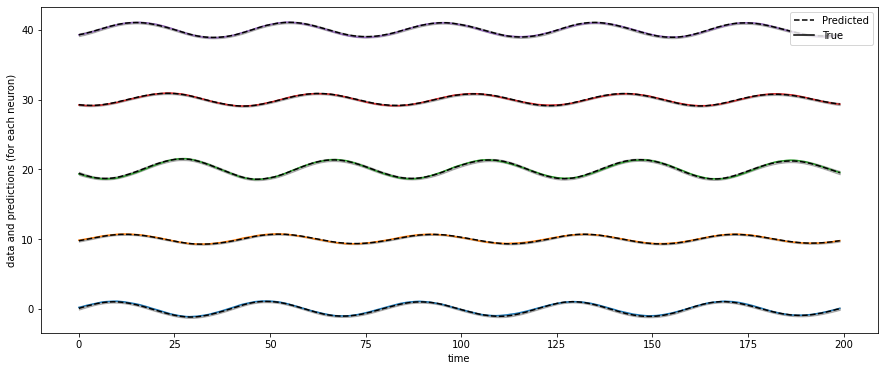

In [14]:
num_emissions_channels_to_view = 5
num_trials_to_view = 2

for trial_idx in range(num_trials_to_view):
    states, data, Ex, Ey, Covy, Ey_true = extract_trial_stats(trial_idx, posteriors, all_data, all_states, fitted_lds, true_lds)
    compare_dynamics(Ex, states, data)
    compare_smoothened_predictions(Ey[:, :num_emissions_channels_to_view],
                                   Ey_true[:, :num_emissions_channels_to_view],
                                   Covy, data[:, :num_emissions_channels_to_view])